##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

このチュートリアルでは、`tf.keras.Sequential`モデルを使って花の画像を分類し、`tf.keras.utils.image_dataset_from_directory`を使ってデータをロードする方法を説明します。以下のコンセプトを実証しています。


* ディスクからデータセットを効率的にロードする。
* オーバーフィットを特定し、それを軽減するためにデータ増強とドロップアウトを含む技術を適用する。

このチュートリアルは、基本的な機械学習のワークフローに従います。

1. データを調査し理解する
2. 入力パイプラインの構築
3. モデルの構築
4. モデルの学習
5. モデルのテスト
6. モデルを改良し、そのプロセスを繰り返す

さらに、このノートブックでは、モバイル、組み込み、IoTデバイスのオンデバイス機械学習のために、[saved model](../../guide/saved_model.ipynb) を [TensorFlow Lite](https://www.tensorflow.org/lite/) モデルに変換する方法を示しています。



In [1]:
#グーグルドライブと同期#★driveから持ってくるsutemeru133にある
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## セットアップ

TensorFlowやその他必要なライブラリをインポートします。

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## データセットのダウンロードとチェック

このチュートリアルでは、約3982枚のダニの写真からなるデータセットを使用します。このデータセットには３つのサブディレクトリがあり、クラスごとに1つずつあります。
```
mitedataset/
  devidedmite/
  mite/
  notmite/

```

In [3]:
#★driveから持ってくるsutemeru133にあるdata2はfastlabelのboundhingbox-mite-detectedを3角度回転、左右反転、crop,noiseで増やしたもの

import shutil
import pathlib
shutil.copy('/content/drive/MyDrive/mitedataset.zip','/content/mitedataset.zip')
shutil.unpack_archive("/content/mitedataset.zip", "/content")
data_dir = pathlib.Path('/content/mitedataset')

ダウンロード後、データセットのコピーが利用できるようになるはずです。合計3982枚の画像があります。

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

13266


ダニがいる画像は

4140 枚


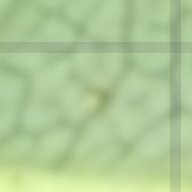

In [5]:
mite = list(data_dir.glob('mite/*'))
print(len(mite),"枚")
PIL.Image.open(str(mite[0]))

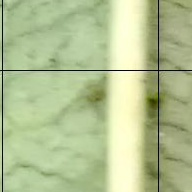

In [ ]:
PIL.Image.open(str(mite[1]))

ダニがいない画像は

8964 枚


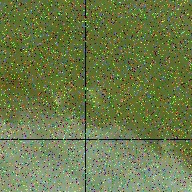

In [6]:
notmite = list(data_dir.glob('notmite/*'))
print(len(notmite),"枚")
PIL.Image.open(str(notmite[0]))

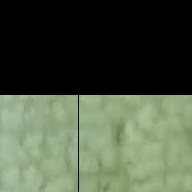

In [ ]:
PIL.Image.open(str(notmite[1]))

重複画像は

162 枚


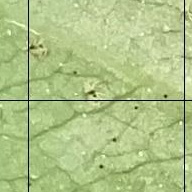

In [7]:
devidedmite = list(data_dir.glob('devidedmite/*'))
print(len(devidedmite),"枚")
PIL.Image.open(str(devidedmite[0]))

## Kerasユーティリティを使用してデータをロードする

次に、有用な `tf.keras.utils.image_dataset_from_directory` ユーティリティを使用してディスクからこれらの画像をロードします。これは、数行のコードで、ディスク上の画像のディレクトリから `tf.data.Dataset` に移動させます。もしよろしければ、[Load and preprocess images](../load_data/images.ipynb) tutorialをご覧いただき、ゼロからご自身のデータ読み込みコードを書くことも可能です。

### データセットの作成



ローダーに関するいくつかのパラメータを定義します。

In [11]:
batch_size = 6
img_height = 192
img_width = 192

モデルを開発する際には、検証用のスプリットを使用するのがよいでしょう。80%の画像をトレーニングに、20%の画像を検証に使用します。

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13266 files belonging to 3 classes.
Using 11940 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13266 files belonging to 3 classes.
Using 1326 files for validation.


これらのデータセットの `class_names` 属性に、クラス名が記載されています。これらは、アルファベット順のディレクトリ名に対応しています。

In [14]:
class_names = train_ds.class_names
print(class_names)

['devidedmite', 'mite', 'notmite']


## データを可視化する

トレーニングデータセットの最初の9枚の画像です。

注：バッチサイズが２なら２つまでしか表記できない



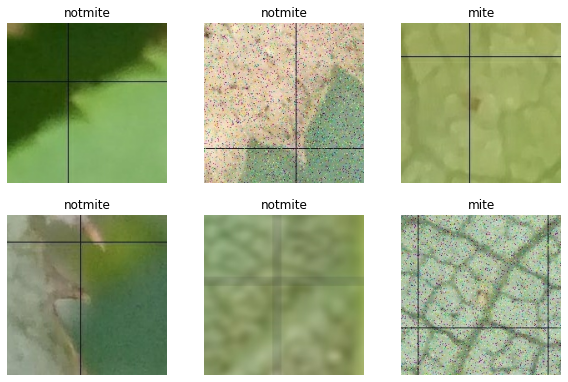

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

このチュートリアルの後半で、これらのデータセットをKerasの `Model.fit` メソッドに渡して学習させることになります。必要であれば、手動でデータセットを繰り返し、画像のバッチを取得することもできます。

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(6, 192, 192, 3)
(6,)


`image_batch` は `(2, 192, 192, 3)` 形式のテンソルである。これは `192x192x3` 形状の2枚の画像のバッチである (最後の次元はカラーチャンネルRGBを参照する)。label_batch` は `(2,)形式のテンソルであり、2枚の画像に対応するラベルを表します。

image_batch`と`labels_batch`のテンソルに対して `.numpy()` を呼び出すと、 `numpy.ndarray` に変換することができます。


## パフォーマンスのためのデータセットの設定

バッファード・プリフェッチを必ず使用し、I/Oがブロック化されることなくディスクからデータを取得できるようにします。この2つは、データを読み込むときに使うべき重要な方法です。

- `Dataset.cache` は、最初のエポック時にディスクから読み込まれた画像をメモリ上に保持します。これにより、モデルの学習中にデータセットがボトルネックになることはありません。データセットが大きすぎてメモリに収まらない場合は、この方法を用いてパフォーマンスの高いオンディスクキャッシュを作成することもできます。
- `Dataset.prefetch` は学習中のデータの前処理とモデルの実行をオーバーラップさせます。

この2つのメソッドについて、またデータをディスクにキャッシュする方法については、[Better performance with the tf.data API](../../guide/data_performance.ipynb) ガイドの *Prefetching* セクションで詳しく説明されているので、興味のある読者は参照してください。

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## データの標準化

RGB チャンネルの値は `[0, 255]` の範囲にあります。これはニューラルネットワークにとって理想的ではありません。一般的には、入力値を小さくすることを追求すべきです。

ここでは、`tf.keras.lays.Rescaling`を使用して、`[0, 1]`の範囲になるように値を標準化します。

In [ ]:
normalization_layer = layers.Rescaling(1./255)

このレイヤーを使うには2つの方法があります。データセットに適用するには、`Dataset.map`を呼び出します。

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


または、モデル定義の中にレイヤーを含めることができ、デプロイメントを簡素化することができます。ここでは、2番目のアプローチを使用します。

注意：以前は `tf.keras.utils.image_dataset_from_directory` の `image_size` 引数を用いて画像のリサイズを行いました。もし、リサイズロジックもモデルに含めたい場合は、`tf.keras.lays.Resizing`レイヤーを使用することが可能です。

## 基本的なKerasモデル

### モデルの作成

Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) モデルは、3つのコンボリューションブロック (`tf.keras.layers.Conv2D`) とそれぞれの中の最大プーリング層 (`tf.keras.layers.MaxPooling2D`) から構成されています。その上に128個のユニットを持つ完全連結層(`tf.keras.lays.Dense`)があり、ReLU活性化関数(`relu'`)で活性化されています。このモデルは高精度のためにチューニングされていません。このチュートリアルの目的は、標準的なアプローチを示すことです。

[newral network console ->kerasの考察](https://www.mgo-tec.com/blog-entry-colab-keras-param01.html#title01)

In [ ]:
#★#最高精度oputuna済み
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None),
  layers.DepthwiseConv2D((2, 4), padding='valid', activation='relu'),
  layers.AveragePooling2D(pool_size=(1, 3), strides=None, padding='valid', data_format=None),
  layers.Dropout(0.17),
  layers.Flatten(data_format=None),  
  layers.Dense(num_classes, activation='sigmoid'),
])

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(pool_size=(8, 2), strides=None, padding='same', data_format=None),
  layers.DepthwiseConv2D((1, 2), padding='same', activation='relu'),
  layers.Dropout(0.4),
  layers.Flatten(),  
  layers.Dense(num_classes, activation='softmax'),  
])

In [ ]:
#詳しく書くと
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, offset=0.0, input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(pool_size=(8,2), strides=(8,2), padding='same', data_format=None),
  layers.DepthwiseConv2D((1, 2),strides=(1, 1),padding='same',depth_multiplier=1,data_format=None,dilation_rate=(1, 1),activation='relu',use_bias=True,depthwise_initializer='glorot_normal',bias_initializer='constant',depthwise_regularizer=None,bias_regularizer=None,activity_regularizer=None,depthwise_constraint=None,bias_constraint=None),
  layers.Dropout(0.4, noise_shape=None, seed=None),
  layers.Flatten(data_format=None),
  layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_initializer='glorot_normal', bias_initializer='constant', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None), 
])

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, offset=0.0, input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(pool_size=(7, 3), strides=(7,3), padding='same', data_format="channels_first"),
  layers.DepthwiseConv2D((1, 2),strides=(1, 1),padding='same',depth_multiplier=1,data_format=None,dilation_rate=(1, 1),activation='relu',use_bias=True,depthwise_initializer='glorot_normal',bias_initializer='constant',depthwise_regularizer=None,bias_regularizer=None,activity_regularizer=None,depthwise_constraint=None,bias_constraint=None),
  layers.Flatten(data_format=None),
  layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_initializer='glorot_normal', bias_initializer='constant', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None), 
])

In [ ]:
#vgg16
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16,kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None),
  layers.Conv2D(16,kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None),
  layers.Conv2D(16,kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same', data_format=None),
  layers.Conv2D(16,kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None),
  layers.Conv2D(16,kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None),
  layers.Conv2D(16,kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same', data_format=None),
  layers.Conv2D(16,kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None),
  layers.Conv2D(16,kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None),
  layers.Conv2D(16,kernel_size=(3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same', data_format=None),
  layers.Flatten(), 
  layers.Dense(1026, activation='relu'), 
  layers.Dropout(0.2),
  layers.Dense(1026, activation='relu'), 
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')  
])

In [22]:
# ★VGG16モデルと学習済み重みをロード
num_classes = len(class_names)
# パーセプトロン部(Fully-connected層)はいらないのでinclude_top=False）
input_tensor = keras.layers.Input(shape=(img_height, img_width, 3))
model_feature = keras.applications.vgg16.VGG16(
                  include_top=False, 
                  weights='imagenet', 
                  input_tensor=input_tensor)
# model_feature.summary()

# 最後の畳み込み層を除く全ての畳み込み層をフリーズする
#for layer in model_feature.layers[:15]:
#    layer.trainable = False

# 転移学習をするときには、畳込み層を全てフリーズする
for layer in model_feature.layers:
    layer.trainable = False

# パーセプトロン部の作成
model_perceptron = keras.models.Sequential()
model_perceptron.add(keras.layers.Flatten(input_shape=model_feature.output_shape[1:]))
model_perceptron.add(keras.layers.Dense(256, activation='relu'))
model_perceptron.add(keras.layers.Dropout(0.5))
model_perceptron.add(keras.layers.Dense(
                      num_classes, 
                      activation='softmax'))


# VGG16とパーセプトロンを接続する
model = keras.models.Model(inputs=model_feature.input, outputs=model_perceptron(model_feature.output))

# ネットワークを作ったら必ずコンパイルする
#model.compile(loss='categorical_crossentropy',
#              optimizer=keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
#              metrics=['accuracy'])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

### モデルのコンパイル

このチュートリアルでは、`tf.keras.optimizers.Adam` オプティマイザと `tf.keras.losses.SparseCategoricalCrossentropy` 損失関数を選択します。各トレーニングエポックのトレーニング精度と検証精度を表示するには、`Model.compile` に `metrics` 引数を渡します。

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1E-8, decay=0.0, amsgrad=False),         
              metrics=['accuracy'])

### モデルの要約

Keras の `Model.summary` メソッドを使用して、ネットワークの全レイヤーを表示します。

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0   

### モデルのトレーニング

Kerasの`Model.fit`メソッドで10エポック分のモデルを学習させます。

In [ ]:
epochs=30#40くらいがベスト？learning_rate=1e-5なら100くらいかかりそう
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
1990/1990 [==============================] - 79s 40ms/step - loss: 0.3434 - accuracy: 0.8315 - val_loss: 0.3783 - val_accuracy: 0.8250
Epoch 2/30
1990/1990 [==============================] - 79s 40ms/step - loss: 0.3308 - accuracy: 0.8432 - val_loss: 0.3732 - val_accuracy: 0.8363
Epoch 3/30
1990/1990 [==============================] - 79s 40ms/step - loss: 0.3308 - accuracy: 0.8440 - val_loss: 0.3703 - val_accuracy: 0.8371
Epoch 4/30
1990/1990 [==============================] - 79s 39ms/step - loss: 0.3213 - accuracy: 0.8440 - val_loss: 0.3627 - val_accuracy: 0.8303
Epoch 5/30
1990/1990 [==============================] - 79s 40ms/step - loss: 0.3105 - accuracy: 0.8518 - val_loss: 0.3405 - val_accuracy: 0.8477
Epoch 6/30
1990/1990 [==============================] - 79s 40ms/step - loss: 0.2981 - accuracy: 0.8640 - val_loss: 0.3531 - val_accuracy: 0.8303
Epoch 7/30
1990/1990 [==============================] - 79s 40ms/step - loss: 0.2878 - accuracy: 0.8622 - val_loss: 0.3610 -

## トレーニング結果の可視化

トレーニングセットとバリデーションセットの損失と精度のプロットを作成します。

[グラフの見方と修正法](https://qiita.com/hiroyuki827/items/213146d551a6e2227810)

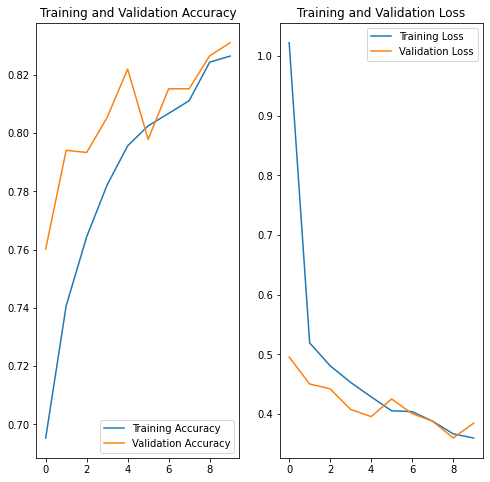

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##oputunaでハイパーパラメータ探索
[参考](https://snova301.hatenablog.com/entry/2018/12/14/191025)

In [ ]:
!pip install optuna

import numpy as np
import optuna

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,Rescaling,DepthwiseConv2D,AveragePooling2D
from keras.utils import np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 KB 16.7 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=360f7efa8379a2471db7cd3d459a3871d828f6f63cf7556e8c12c0a6b438426e
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  A

In [ ]:
#def create_model(n_layer,activation1,activation2,activation3, mid_units, dropout_rate):
def create_model(activation1,activation3, dropout_rate):
    
    model = Sequential()

    model.add(Rescaling(1./255, offset=0.0, input_shape=(192, 192, 3)))

    #for i in range(n_layer):
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(7,3), padding='same', data_format="channels_first"))
    model.add(DepthwiseConv2D((2, 4),strides=(2, 2),padding='same',data_format=None, activation=activation1))
    
    model.add(AveragePooling2D(pool_size=(1, 3), strides=None, padding='valid', data_format=None))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(2, activation=activation3))
 
    return model

def objective(trial):
    # データをロード
    #x_train, y_train, x_test, y_test = MNIST_data()

    # 調整したいハイパーパラメータの設定
    #n_layer = trial.suggest_int('n_layer', 1, 3) # 追加する層を1-3から選ぶ
    #mid_units = int(trial.suggest_float('mid_units', 100, 500, step=100)) # ユニット数#不使用
    dropout_rate = trial.suggest_float('dropout_rate', 0, 1) # ドロップアウト率
    activation1 = trial.suggest_categorical('activation1', ['relu', 'sigmoid']) # 活性化関数1
    #activation2 = trial.suggest_categorical('activation2', ['relu', 'sigmoid']) # 活性化関数2#不使用
    activation3 = trial.suggest_categorical('activation3', ['relu', 'sigmoid']) # 活性化関数3
    optimizer = trial.suggest_categorical('optimizer', ['sgd', 'adam', 'rmsprop']) # 最適化アルゴリズム

    # 学習モデルの構築と学習の開始
    #model = create_model(n_layer, activation1,activation2,activation3, mid_units, dropout_rate)
    model = create_model(activation1,activation3, dropout_rate)
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])
    history = model.fit(train_ds, 
                        epochs=20,
                        validation_data=val_ds)


    # 学習モデルの保存
    model_json = model.to_json()
    with open('keras_model.json', 'w') as f_model:
        f_model.write(model_json)
    model.save_weights('keras_model.hdf5')

    # 最小値探索なので
    return -np.amax(history.history['val_accuracy'])


def main():
    study = optuna.create_study(sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=10)
    print('best_params')
    print(study.best_params)
    print('-1 x best_value')
    print(-study.best_value)

    print('\n --- sorted --- \n')
    sorted_best_params = sorted(study.best_params.items(), key=lambda x : x[0])
    for i, k in sorted_best_params:
        print(i + ' : ' + str(k))

if __name__ == '__main__':
  main()

[I 2023-01-11 04:23:57,847] A new study created in memory with name: no-name-2471653c-8fc7-4531-bb76-cf00fe6bf647


Epoch 1/20
3932/3932 [==============================] - 16s 4ms/step - loss: 0.7251 - accuracy: 0.3189 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 2/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 3/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 4/20
3932/3932 [==============================] - 14s 4ms/step - loss: 0.6968 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 5/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 6/20
3932/3932 [==============================] - 15s 4ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 7/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_ac

[I 2023-01-11 04:29:15,916] Trial 0 finished with value: -0.2821100950241089 and parameters: {'dropout_rate': 0.35075348512365356, 'activation1': 'sigmoid', 'activation3': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: -0.2821100950241089.


Epoch 1/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6290 - accuracy: 0.6801 - val_loss: 0.5950 - val_accuracy: 0.7179
Epoch 2/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6276 - accuracy: 0.6803 - val_loss: 0.6006 - val_accuracy: 0.7179
Epoch 3/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6279 - accuracy: 0.6803 - val_loss: 0.5992 - val_accuracy: 0.7179
Epoch 4/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6279 - accuracy: 0.6803 - val_loss: 0.5956 - val_accuracy: 0.7179
Epoch 5/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6279 - accuracy: 0.6803 - val_loss: 0.5983 - val_accuracy: 0.7179
Epoch 6/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6280 - accuracy: 0.6803 - val_loss: 0.5981 - val_accuracy: 0.7179
Epoch 7/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6279 - accuracy: 0.6803 - val_loss: 0.5950 - val_ac

[I 2023-01-11 04:33:57,362] Trial 1 finished with value: -0.7178899049758911 and parameters: {'dropout_rate': 0.15508536795355132, 'activation1': 'relu', 'activation3': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 1 with value: -0.7178899049758911.


Epoch 1/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.5957 - accuracy: 0.6757 - val_loss: 0.5486 - val_accuracy: 0.7248
Epoch 2/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5726 - accuracy: 0.6859 - val_loss: 0.5250 - val_accuracy: 0.7179
Epoch 3/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5640 - accuracy: 0.6966 - val_loss: 0.5187 - val_accuracy: 0.7156
Epoch 4/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5582 - accuracy: 0.6933 - val_loss: 0.5104 - val_accuracy: 0.7225
Epoch 5/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5525 - accuracy: 0.7022 - val_loss: 0.5184 - val_accuracy: 0.7454
Epoch 6/20
3932/3932 [==============================] - 10s 3ms/step - loss: 0.5429 - accuracy: 0.6963 - val_loss: 0.5143 - val_accuracy: 0.7523
Epoch 7/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5480 - accuracy: 0.6994 - val_loss: 0.5016 - val_ac

[I 2023-01-11 04:39:20,234] Trial 2 finished with value: -0.7660550475120544 and parameters: {'dropout_rate': 0.5443626573126812, 'activation1': 'sigmoid', 'activation3': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 2 with value: -0.7660550475120544.


Epoch 1/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.7112 - accuracy: 0.3192 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 2/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 3/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 4/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 5/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 6/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 7/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_ac

[I 2023-01-11 04:44:06,024] Trial 3 finished with value: -0.2821100950241089 and parameters: {'dropout_rate': 0.5277253443517993, 'activation1': 'sigmoid', 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 2 with value: -0.7660550475120544.


Epoch 1/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.7361 - accuracy: 0.3210 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 2/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 3/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 4/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 5/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 6/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 7/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_ac

[I 2023-01-11 04:49:24,347] Trial 4 finished with value: -0.2821100950241089 and parameters: {'dropout_rate': 0.08753394174079254, 'activation1': 'sigmoid', 'activation3': 'relu', 'optimizer': 'rmsprop'}. Best is trial 2 with value: -0.7660550475120544.


Epoch 1/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6248 - accuracy: 0.6778 - val_loss: 0.5815 - val_accuracy: 0.7179
Epoch 2/20
3932/3932 [==============================] - 10s 3ms/step - loss: 0.6061 - accuracy: 0.6841 - val_loss: 0.5643 - val_accuracy: 0.7271
Epoch 3/20
3932/3932 [==============================] - 10s 3ms/step - loss: 0.5952 - accuracy: 0.6892 - val_loss: 0.5631 - val_accuracy: 0.7202
Epoch 4/20
3932/3932 [==============================] - 10s 3ms/step - loss: 0.5908 - accuracy: 0.6928 - val_loss: 0.5516 - val_accuracy: 0.7248
Epoch 5/20
3932/3932 [==============================] - 10s 3ms/step - loss: 0.5858 - accuracy: 0.6981 - val_loss: 0.5460 - val_accuracy: 0.7317
Epoch 6/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5792 - accuracy: 0.6958 - val_loss: 0.5399 - val_accuracy: 0.7339
Epoch 7/20
3932/3932 [==============================] - 10s 3ms/step - loss: 0.5792 - accuracy: 0.7024 - val_loss: 0.5571 - val_ac

[I 2023-01-11 04:53:46,223] Trial 5 finished with value: -0.7454128265380859 and parameters: {'dropout_rate': 0.5248973866267381, 'activation1': 'relu', 'activation3': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 2 with value: -0.7660550475120544.


Epoch 1/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6301 - accuracy: 0.6653 - val_loss: 0.5460 - val_accuracy: 0.7179
Epoch 2/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5805 - accuracy: 0.6803 - val_loss: 0.5405 - val_accuracy: 0.7179
Epoch 3/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5669 - accuracy: 0.6831 - val_loss: 0.5210 - val_accuracy: 0.7179
Epoch 4/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5612 - accuracy: 0.6902 - val_loss: 0.5124 - val_accuracy: 0.7179
Epoch 5/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5553 - accuracy: 0.6991 - val_loss: 0.5121 - val_accuracy: 0.7362
Epoch 6/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5523 - accuracy: 0.6979 - val_loss: 0.5140 - val_accuracy: 0.7546
Epoch 7/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5496 - accuracy: 0.7012 - val_loss: 0.5093 - val_ac

[I 2023-01-11 04:58:21,445] Trial 6 finished with value: -0.7637614607810974 and parameters: {'dropout_rate': 0.6520324804833091, 'activation1': 'sigmoid', 'activation3': 'sigmoid', 'optimizer': 'adam'}. Best is trial 2 with value: -0.7660550475120544.


Epoch 1/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6994 - accuracy: 0.3199 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 2/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 3/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 4/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 5/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 6/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 7/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_ac

[I 2023-01-11 05:04:22,737] Trial 7 finished with value: -0.2821100950241089 and parameters: {'dropout_rate': 0.32252239144179573, 'activation1': 'relu', 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 2 with value: -0.7660550475120544.


Epoch 1/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6558 - accuracy: 0.6704 - val_loss: 0.5944 - val_accuracy: 0.7179
Epoch 2/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6044 - accuracy: 0.6785 - val_loss: 0.5585 - val_accuracy: 0.7087
Epoch 3/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.5458 - accuracy: 0.6831 - val_loss: 0.4926 - val_accuracy: 0.7317
Epoch 4/20
3932/3932 [==============================] - 13s 3ms/step - loss: 0.5192 - accuracy: 0.7085 - val_loss: 0.5028 - val_accuracy: 0.7523
Epoch 5/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5111 - accuracy: 0.7279 - val_loss: 0.4994 - val_accuracy: 0.7339
Epoch 6/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.5044 - accuracy: 0.7416 - val_loss: 0.5301 - val_accuracy: 0.7477
Epoch 7/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.4996 - accuracy: 0.7365 - val_loss: 0.4888 - val_ac

[I 2023-01-11 05:09:08,219] Trial 8 finished with value: -0.7683486342430115 and parameters: {'dropout_rate': 0.17043259096747632, 'activation1': 'relu', 'activation3': 'sigmoid', 'optimizer': 'adam'}. Best is trial 8 with value: -0.7683486342430115.


Epoch 1/20
3932/3932 [==============================] - 12s 3ms/step - loss: 0.9550 - accuracy: 0.3395 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 2/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6940 - accuracy: 0.3210 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 3/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 4/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 5/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 6/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6957 - accuracy: 0.3197 - val_loss: 0.6931 - val_accuracy: 0.2821
Epoch 7/20
3932/3932 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.3197 - val_loss: 0.6931 - val_ac

[I 2023-01-11 05:14:45,789] Trial 9 finished with value: -0.2821100950241089 and parameters: {'dropout_rate': 0.79750912061673, 'activation1': 'relu', 'activation3': 'relu', 'optimizer': 'adam'}. Best is trial 8 with value: -0.7683486342430115.


best_params
{'dropout_rate': 0.17043259096747632, 'activation1': 'relu', 'activation3': 'sigmoid', 'optimizer': 'adam'}
-1 x best_value
0.7683486342430115

 --- sorted --- 

activation1 : relu
activation3 : sigmoid
dropout_rate : 0.17043259096747632
optimizer : adam


プロットは、トレーニング精度と検証精度が大きくずれており、モデルは検証セットで60%程度の精度しか達成できていないことを示しています。

以下のチュートリアルでは、何が問題だったのかを検証し、モデルの全体的なパフォーマンスを向上させる方法を説明します。

## オーバーフィット

上のプロットでは、学習精度が時間とともに直線的に上昇しているのに対し、検証精度は学習過程の60%付近で停滞しています。また、学習精度と検証精度の差が顕著であり、[overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)の兆候が見られます。

学習例が少ない場合、モデルは学習例からノイズや不要な部分を学習し、それが新しい例に対するモデルの性能に悪影響を与えることがあります。このような現象はオーバーフィットと呼ばれます。これは、モデルが新しいデータセットで汎化するのが難しくなることを意味します。

学習プロセスにおいてオーバーフィットに対抗する方法は複数あります。このチュートリアルでは、*data augmentation*を使用し、*dropout*をモデルに追加します。

## データ拡張

一般的にオーバーフィッティングは、学習例が少ない場合に発生します。[Data augmentation](./data_augmentation.ipynb) は、既存の学習データから、信頼できそうな画像を生成するランダムな変換を使用して学習データを追加生成するアプローチを取ります。これにより、モデルがデータのより多くの側面に触れ、より良く汎化することができます。

以下のKerasの前処理レイヤーを使用してデータ増強を実装します：`tf.keras.lays.RandomFlip`, `tf.keras.layers.RandomRotation`, そして `tf.keras.lays.RandomZoom`。これらは他のレイヤーのようにモデル内に含めることができ、GPU上で実行することができます。

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

同じ画像に何度かデータ補強を施して、補強した例をビジュアル化します。

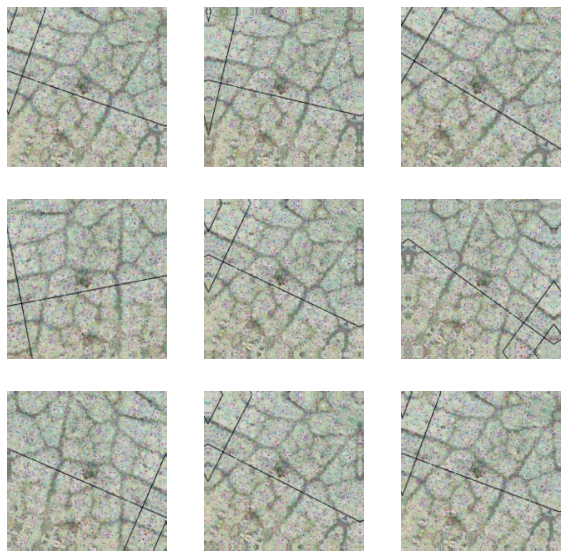

In [ ]:
#batchサイズか、どこかの処理を繰り返し行うと動かなくなる
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

次のステップでトレーニングする前に、モデルにデータ拡張を追加します。

## ドロップアウト

オーバーフィッティングを減らすもう一つの手法は、ネットワークに [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} 正則化を導入することである。

ドロップアウトを適用すると、学習中にレイヤーからランダムに出力ユニットが（活性化をゼロにして）ドロップアウトされます。ドロップアウトは0.1、0.2、0.4などの小数値を入力値として受け取ります。これは、適用された層からランダムに10％、20％、40％の出力ユニットをドロップアウトすることを意味します。

新しいニューラルネットワークを `tf.keras.layers.Dropout` で作成してから、拡張された画像を使ってトレーニングします。

In [ ]:
#★flattenない
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, offset=0.0, input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(pool_size=(7, 3), strides=(7,3), padding='same', data_format="channels_first"),
  layers.DepthwiseConv2D((1, 2),strides=(1, 1),padding='same',depth_multiplier=1,data_format=None,dilation_rate=(1, 1),activation='relu',use_bias=True,depthwise_initializer='glorot_normal',bias_initializer='constant',depthwise_regularizer=None,bias_regularizer=None,activity_regularizer=None,depthwise_constraint=None,bias_constraint=None),
  layers.Dropout(0.2),
  layers.Flatten(data_format=None),
  layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_initializer='glorot_normal', bias_initializer='constant', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None), 
])

In [ ]:
#もともと
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## モデルのコンパイルと学習

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1E-8, decay=0.0, amsgrad=False),         
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 192, 192, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 192, 192, 3)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 192, 28, 1)       0         
 2D)                                                             
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 192, 28, 1)       3         
 seConv2D)                                                       
                                                                 
 dropout (Dropout)           (None, 192, 28, 1)        0         
                                                                 
 flatten_1 (Flatten)         (None, 5376)             

In [ ]:
epochs =50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
3186/3186 [==============================] - 17s 5ms/step - loss: 1.2422 - accuracy: 0.4674 - val_loss: 0.9584 - val_accuracy: 0.5364
Epoch 2/50
3186/3186 [==============================] - 16s 5ms/step - loss: 0.9211 - accuracy: 0.5276 - val_loss: 0.8846 - val_accuracy: 0.5716
Epoch 3/50
3186/3186 [==============================] - 16s 5ms/step - loss: 0.8557 - accuracy: 0.5681 - val_loss: 0.8456 - val_accuracy: 0.6043
Epoch 4/50
3186/3186 [==============================] - 16s 5ms/step - loss: 0.8170 - accuracy: 0.6099 - val_loss: 0.8578 - val_accuracy: 0.6269
Epoch 5/50
3186/3186 [==============================] - 16s 5ms/step - loss: 0.8098 - accuracy: 0.6237 - val_loss: 0.8610 - val_accuracy: 0.6319
Epoch 6/50
3186/3186 [==============================] - 16s 5ms/step - loss: 0.8027 - accuracy: 0.6174 - val_loss: 0.8941 - val_accuracy: 0.6156
Epoch 7/50
3186/3186 [==============================] - 17s 5ms/step - loss: 0.8008 - accuracy: 0.6218 - val_loss: 0.9810 - val_ac

KeyboardInterrupt: ignored

## 学習結果の可視化

データ拡張と `tf.keras.layers.Dropout` を適用した結果、オーバーフィットが以前より減少し、学習と検証の精度がより一致するようになりました。

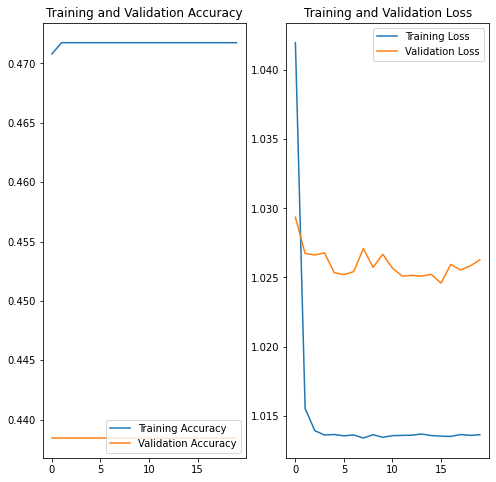

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 新しいデータで予測する

トレーニングセットやバリデーションセットに含まれていない画像を、モデルを使って分類します。

注：データ補強層とドロップアウト層は推論時には非活性である。

In [ ]:
#★テスト画像をダウンロード
#!wget -O "/content/Red_sunflower.jpg" "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = pathlib.Path('/content/mitedataset/notmite/DSC_0270_000grid_1209_0185_c0090_x0000_y0000_o.jpg')
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 19ms/step
This image most likely belongs to notmite with a 56.79 percent confidence.


## TensorFlow Liteを使う

TensorFlow Liteは、開発者がモバイル、組み込み、およびエッジデバイス上でモデルを実行できるようにすることで、オンデバイス機械学習を可能にするツールセットです。

### Keras SequentialモデルをTensorFlow Liteモデルに変換する

学習したモデルをオンデバイスで使用するには、まず[TensorFlow Lite](https://www.tensorflow.org/lite/)モデルと呼ばれる、より小さく効率的なモデル形式に[変換](https://www.tensorflow.org/lite/models/convert)します。

この例では、学習済みのKeras Sequentialモデルを、`tf.lite.TFLiteConverter.from_keras_model`を使って[TensorFlow Lite](https://www.tensorflow.org/lite/) モデルを生成している。

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

前のステップで保存したTensorFlow Liteモデルには、複数の関数シグネチャを含めることができます。Kerasのモデル変換APIは、自動的にデフォルトのシグネチャを使用します。[TensorFlow Liteのシグネチャ](https://www.tensorflow.org/lite/guide/signatures)について詳しくはこちら。

#★ TensorFlow Lite モデルの実行

TensorFlow Lite で保存したモデルのシグネチャは、Python の `tf.lite.Interpreter` クラスを介してアクセスすることができる。

モデルを `Interpreter` でロードする。

In [ ]:
#グーグルドライブと同期#★driveから持ってくるsutemeru132にある
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#事前準備
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#ドライブからモデルをコピー#★driveから持ってくるsutemeru132にある
import shutil
import pathlib
shutil.copy('/content/drive/MyDrive/model.tflite','/content/model.tflite')

'/content/model.tflite'

In [4]:
#テスト用画像をロード
testimg_path = pathlib.Path('/content/drive/MyDrive/mitedataset/mitedataset/notmite/DSC_0270_000grid_1209_0185_c0090_x0000_y0000_o.jpg')

img = tf.keras.utils.load_img(
    testimg_path, target_size=(192, 192)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [5]:
#class_names =['devidedmite', 'mite', 'notmite']
class_names =['2', '1', '0']

In [6]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

変換後のモデルから署名を出力し、入力（および出力）の名前を取得します。

In [7]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['input_2'], 'outputs': ['sequential_1']}}

この例では、`serving_default` という名前のデフォルトシグネチャを一つ持っている。また、 `'inputs'` の名前は `'sequential_1_input'` で、 `'output'` は `'outputs'` と呼ばれています。これらの最初と最後のKerasレイヤーの名前は、このチュートリアルの前半で示したように、 `Model.summary` を実行するときに調べることができます。

次に、サンプル画像に対して `tf.lite.Interpreter.get_signature_runner` で署名名を渡して推論を行い、ロードした TensorFlow Model をテストすることができる。

In [8]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

チュートリアルの前半で行ったことと同様に、TensorFlow Liteモデルを使って、トレーニングセットや検証セットに含まれていない画像を分類することができます。

すでにその画像はテンソル化され、`img_array`という名前で保存されています。次に、ロードした TensorFlow Lite モデル (`predictions_lite`) の第一引数 (`'inputs'`) に渡し、ソフトマックスのアクティブ度を計算し、計算した確率が最も高いクラスの予測を出力する。

In [9]:
#predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
predictions_lite = classify_lite(input_2=img_array)['sequential_1']
score_lite = tf.nn.softmax(predictions_lite)

In [10]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to 1 with a 73.11 percent confidence.


ライトモデルで生成された予測値は、オリジナルモデルで生成された予測値とほぼ同じになるはずです。

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

7.4505806e-08


デイジー'`、タンポポ'`、バラ'`、ヒマワリ'`、チューリップ'`の5クラスのうち、ヒマワリに属すると予測するはずですが、これはTensorFlow Lite変換前と同じ結果になりました。


##TensorFlow Lite->ONNX

In [ ]:
!pip install tflite2onnx

In [ ]:
import tflite2onnx

tflite_path = '/content/model.tflite'
onnx_path = '/content/model.onnx'

tflite2onnx.convert(tflite_path, onnx_path)

In [ ]:
!pip install onnx-tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 226 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 64.2 MB/s 


## ONNX->TensorFlow

In [ ]:
!sudo add-apt-repository -y ppa:deadsnakes/ppa
!sudo apt-get -y update
!sudo apt-get -y install python3.9
!sudo apt-get -y install python3.9-dev
!sudo apt-get -y install python3-pip
!sudo apt-get -y install python3.9-distutils
!python3.9 -m pip install -U setuptools \
  && python3.9 -m pip install -U pip \
  && python3.9 -m pip install -U distlib
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2
!python3.9 -m pip install tensorflow==2.10.0 \
  && python3.9 -m pip install -U onnx \
  && python3.9 -m pip install -U nvidia-pyindex \
  && python3.9 -m pip install -U onnx-graphsurgeon \
  && python3.9 -m pip install -U onnxsim \
  && python3.9 -m pip install -U simple_onnx_processing_tools \
  && python3.9 -m pip install -U onnx2tf

In [ ]:
!onnx2tf -i /content/model.onnx -oiqt 

## 次のステップ

このチュートリアルでは、画像分類のためのモデルの学習、テスト、オンデバイスアプリケーション（画像分類アプリなど）用のTensorFlow Lite形式への変換、Python APIによるTensorFlow Liteモデルでの推論の方法を示しました。

TensorFlow Liteについては、[チュートリアル](https://www.tensorflow.org/lite/tutorials)や[ガイド](https://www.tensorflow.org/lite/guide)で詳しく説明されています。